In [1]:
# Import all the packages needed to run the AutoML framework.

import pandas as pd
import numpy as np
import math
import hyperopt
from hyperopt import fmin, tpe, hp,space_eval,Trials
from hpsklearn import all_regressors
from sklearn.pipeline import Pipeline
from sklearn.kernel_approximation import Nystroem
from sklearn.preprocessing import QuantileTransformer,StandardScaler,MinMaxScaler,RobustScaler,FunctionTransformer
from sklearn.model_selection import GroupKFold
from sklearn.compose import TransformedTargetRegressor
from sklearn.decomposition import FastICA, PCA
from hyperopt.early_stop import no_progress_loss
from sklearn.model_selection import cross_val_score
from hyperopt.pyll.base import scope
import warnings
from sklearn.exceptions import ConvergenceWarning
import os
import pickle
from joblib import dump, load
from functools import partial

In [2]:
# Now, some auxiliary functions are presented.

# The function buil_dict(mdl_base) builds a dictionary of pre-established spaces for the Bayesian optimization of the hyperparameters of model "mdl_base".
def buil_dict(mdl_base):
    lst = mdl_base.named_args
    dictn={}
    for ll in lst:
        dictn[ll[0]]=ll[1]
    return dictn

# The function removekeys(d,keys) manipulates a dictionary "d" and remove keys in the list "keys" from it.
def removekeys(d, keys):
    r = dict(d)
    for keyv in keys:
        del r[keyv]
    return r

# The function e_from_Psi(psiv,lambdav,gamma,p0) calculates the value of the void ratio corresponding to the psi value considered.
def e_from_Psi(psiv,lambdav,gamma,p0):
    return psiv + (gamma - lambdav * np.log(p0))

# The function moving_average(x, w) computes the moving average of array x with a window of size w.
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [3]:
# We now define the function which will carry out the AutoML task we chose (predict input simulation parameters from the triaxial
#  test results). This is performed by the function AutoML, whose arguments are:
#   a) random_state: an integer which sets the random seed of the code to ensure reproducibility of the algorithm;
#   b) outer_folds: number of folds for the GroupKFold cross validation used during model selection;
#   c) inner_folds: number of folds for the GroupKFold cross validation used during hyperparameter tuning;
#   d) all_candidates: candidate models to be trained and compared;
#   e) features: input dataset (results of triaxial tests in our case).
#   f) outputs: output dataset (14 parameters, being 10 related to the soil and 4 to the test conditions).
#   g) typev: type of triaxial test considered (Drained or Undrained);
#   h) groups_all: groups for all the features;
#   i) ori_path: path where the train/validation datasets are;
# The function AutoML outputs a simple string "ok". It also saves the learning results to disk, for usage and manipulation latter.
# The function AutoML saves one list to disk, which contains:
#  a) [mdl_name,"CV_outer-"+str(pvi),np.array([yhat.flatten(),y_test.flatten()]),tf_1,k_m,d_r,tf_2,bst_mdl.get_params()], where:
#   a.1) mdl_name: model name;
#   a.2) "CV_outer-"+str(pvi): label string, indicating to which outer folder the following list elements refer to;
#   a.3) np.array([yhat.flatten(),y_test.flatten()]): predicted and real output values;
#   a.4) tf_1,k_m,d_r,tf_2: the best input-processing, kernel, dimensionality reduction and output-processing found after Bayesian optimization, respectively;
#   a.5) bst_mdl.get_params(): the best hyperparemeters found after Bayesian optimization;
# The function AutoML also saves the fitted and optimized production model to disk into the path: ori_path+"Models_"+typev+"\\"+mdl_name+'_production.joblib'

def AutoML(random_state,outer_folds,inner_folds,all_candidates,features,outputs,typev,groups_all,ori_path):
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    warnings.filterwarnings("ignore", category=ConvergenceWarning) 
    warnings.filterwarnings("ignore", category=UserWarning)
    for linev in outputs:
        linev[10] = e_from_Psi(linev[10],linev[1],linev[0],linev[11])
    ns,nt,nf = features.shape
    flat_inps = np.array([x.flatten() for x in features])
    
    results=[]
     
    X_A = flat_inps
    y_A = outputs
    
    cv_outer = GroupKFold(n_splits=outer_folds)
    cv_inner = GroupKFold(n_splits=inner_folds)
    
    for mdl_info in all_candidates:
        mdl_name,mdl_type,space = mdl_info
        print(mdl_name)
                
        space['transf_1'] = hp.choice('transf_1',
        [
            {'type': StandardScaler()},
            {'type': MinMaxScaler()},
            {'type': RobustScaler()},
            {'type': QuantileTransformer(),'output_distribution': hp.choice('quantile_transform_output_distribution_1', ["normal","uniform"])},
             
        ])
        
        space['kernel_method'] = hp.pchoice('kernel_method',
        [
            (0.3,{'type': FunctionTransformer()}),
            (0.7,{'type': Nystroem(),
             'gamma': hp.uniform('gammav', 0.0, 1.0),
             'n_components': int(ns*nt*nf/100),
             'coef0': hp.uniform('coef0v', 0.0, 1.0),
             'kernel': hp.choice('kernelval', [ "cosine", "linear", "poly", "polynomial", "rbf","laplacian", "sigmoid"]),
            'degree': scope.int(hp.quniform('degreev', 1, 10, 1))}),
        ])

        space['dim_reduc'] = hp.pchoice('dim_reduc',
        [
            (0.4,{'type':PCA(), 'n_components': scope.int(hp.quniform('npca', 1, int(nt*nf*0.7), 5)),'svd_solver': 'randomized','random_state':random_state}),
            (0.4,{'type': FastICA(), 'n_components': scope.int(hp.quniform('nica', 1, int(nt*nf*0.7), 5)), 'random_state': random_state}),
            (0.2,{'type': FunctionTransformer()}),
        ]) 
        
        space['transf_2'] = hp.choice('transf_2',
        [
            {'type': StandardScaler()},
            {'type': MinMaxScaler()},
            {'type': RobustScaler()},
            {'type': QuantileTransformer(),'output_distribution': hp.choice('quantile_transform_output_distribution_2', ["normal","uniform"])},
             
        ])
        
        def inner_Search(X_Av,y_Av,gpv):
            mdl = hyperopt.pyll.stochastic.sample(mdl_type)
            def objective(params,X_train_i=X_Av,y_train_i=y_Av,tscv=cv_inner,groups=gpv):
                scoring = 'neg_mean_absolute_percentage_error'
                tt1 = params['transf_1']
                km1 = params['kernel_method']
                dr1 = params['dim_reduc']
                tt2 = params['transf_2']
                pipeline = Pipeline([('transformer', tt1['type'].set_params(**removekeys(tt1, ['type']))),
                                     ('nonlinear', km1['type'].set_params(**removekeys(km1, ['type']))),
                                     ('dim_reduction', dr1['type'].set_params(**removekeys(dr1, ['type']))),
                                     ('estimator', TransformedTargetRegressor(
                                         regressor = mdl.set_params(**removekeys(params, 
                                                                                 ['transf_1','kernel_method','dim_reduc','transf_2'])),
                                         transformer = tt2['type'].set_params(**removekeys(tt2, ['type']))
                                     ))])
                scr = -cross_val_score(pipeline, X_train_i, y_train_i, cv = tscv,n_jobs=-1,scoring=scoring, groups = groups).mean()
                return scr
            
            best=fmin(fn=objective,
                    space=space, 
                    verbose=True,
                    algo=partial(tpe.suggest, n_startup_jobs=60), 
                    max_evals=1500, 
                    early_stop_fn=no_progress_loss(10),
                    rstate=np.random.default_rng(random_state),
                  )
            best_par = space_eval(space, best)
            best_par_mdln = removekeys(best_par,['transf_1','kernel_method','dim_reduc','transf_2'])
            return best_par['transf_1'],best_par['kernel_method'],best_par['dim_reduc'],best_par['transf_2'],mdl.set_params(**best_par_mdln)    

        pvi = 0
        
        for train_ix, test_ix in cv_outer.split(X_A,groups = groups_all):
            
            X_train, X_test = X_A[train_ix, :], X_A[test_ix, :]
            y_train, y_test = y_A[train_ix], y_A[test_ix]
            gp_train, gp_test = groups_all[train_ix], groups_all[test_ix]
            
            tf_1,k_m,d_r,tf_2,bst_mdl_hyp = inner_Search(X_train,y_train,gp_train)

            pipeline_out2 = Pipeline([('transformer', tf_1['type'].set_params(**removekeys(tf_1, ['type']))),
                                         ('nonlinear', k_m['type'].set_params(**removekeys(k_m, ['type']))),
                                         ('dim_reduction', d_r['type'].set_params(**removekeys(d_r, ['type']))),
                                         ('estimator', TransformedTargetRegressor(
                                             regressor = bst_mdl_hyp,
                                             transformer = tf_2['type'].set_params(**removekeys(tf_2, ['type']))
                                         ))])

            bst_mdl = pipeline_out2.fit(X_train,y_train)

            yhat = bst_mdl.predict(X_test)
 
            results.append([mdl_name,"CV_outer-"+str(pvi),np.array([yhat.flatten(),y_test.flatten()]),tf_1,k_m,d_r,tf_2,bst_mdl.get_params()])

            pvi=pvi+1

        tf_1_prod,k_m_prod,d_r_prod,tf_2_prod,bst_mdl_prod = inner_Search(X_A,y_A,groups_all)

        pipeline_prod = Pipeline([('transformer', tf_1_prod['type'].set_params(**removekeys(tf_1_prod, ['type']))),
                                         ('nonlinear', k_m_prod['type'].set_params(**removekeys(k_m_prod, ['type']))),
                                         ('dim_reduction', d_r_prod['type'].set_params(**removekeys(d_r_prod, ['type']))),
                                         ('estimator', TransformedTargetRegressor(
                                             regressor = bst_mdl_prod,
                                             transformer = tf_2_prod['type'].set_params(**removekeys(tf_2_prod, ['type']))
                                         ))])

        mdl_prod = pipeline_prod.fit(X_A,y_A)
        
        results.append([mdl_name,"Prod",np.array([0,0]),tf_1_prod,k_m_prod,d_r_prod,tf_2_prod,mdl_prod.get_params()])

        try:
            os.mkdir(os.path.join(ori_path,"Models_"+typev+"\\")) 
        except:
            pass
        pre_string = ori_path+"Models_"+typev+"\\"
        with open(pre_string+mdl_name+"-r", "wb") as f:
            pickle.dump([x for x in results if x[0]==mdl_name], f)
            
        dump(mdl_prod, pre_string+mdl_name+'_production.joblib')
        
    return "ok"

In [4]:
# To illustrate the usage of the code, we will import some data from Ozelim et al. (2024):

n_soils = 256
n_test_configs = 18

path_root = "D:\\AutoML\\"

# We now import the files that will be used for training.

Txl_256_18_D = np.load(path_root+"txltsts_"+str('Drained')+"_"+str(n_soils)+"_"+str(n_test_configs)+".npy")
Par_256_18_D = np.load(path_root+"features_"+str('Drained')+"_"+str(n_soils)+"_"+str(n_test_configs)+".npy")

Txl_256_18_U = np.load(path_root+"txltsts_"+str('Undrained')+"_"+str(n_soils)+"_"+str(n_test_configs)+".npy")
Par_256_18_U = np.load(path_root+"features_"+str('Undrained')+"_"+str(n_soils)+"_"+str(n_test_configs)+".npy")

# These are just auxiliary variables used to define particular arrays of interest.
comb_Txl_D = Txl_256_18_D
comb_Txl_U = Txl_256_18_U

comb_par_D = Par_256_18_D
comb_par_U = Par_256_18_U

# Since we are using a group k-fold CV scheme, we must define the groups of the samples. Groups refer to specific soil types (the 10 constitutive parameters).
groups = np.array([[k]*n_test_configs for k in range(n_soils)]).flatten()

In [5]:
# We can define the list of models to be considered. To do that, we import the models from hpsklearn with their respective search spaces.

all_candidates = [[x.name,x,buil_dict(x)] for x in all_regressors("reg").inputs()]
Chapter_AutoML = [
         'sklearn_PLSRegression',
        'sklearn_Lasso',
        'sklearn_ElasticNet',
        # 'sklearn_KNeighborsRegressor',
        'sklearn_MLPRegressor',
        'sklearn_ExtraTreeRegressor',
          'sklearn_LinearRegression',
          # 'sklearn_XGBRegressor',
          # 'sklearn_LGBMRegressor',
          'sklearn_GaussianProcessRegressor'
        ]
models_search = [x for x in all_candidates if x[0] in Chapter_AutoML]

In [ ]:
# It is now possible to run the AutoML framework for the dataset and ML models chosen.

random_state = 10
outer_folds = 5
inner_folds = 15
typev = 'Drained'
AutoML(random_state,outer_folds,inner_folds,models_search,comb_Txl_D,comb_par_D,typev,groups,path_root)

sklearn_LinearRegression
  0%|                                           | 1/1500 [00:55<22:58:12, 55.17s/trial, best loss: 0.23011591931184133]

In [ ]:
typev = 'Undrained'
AutoML(random_state,outer_folds,inner_folds,models_search,comb_Txl_U,comb_par_U,typev,groups,path_root)

Auxiliary plots

In [6]:
# It is possible to plot some graphs to understand the results data is distributed.
import skill_metrics as sm
import matplotlib.pyplot as plt
import matplotlib.colors as clr

try:
    os.mkdir(os.path.join(path_root,"Figs_PDF\\")) 
except:
    pass

try:
    os.mkdir(os.path.join(path_root,"Figs_PNG\\")) 
except:
    pass

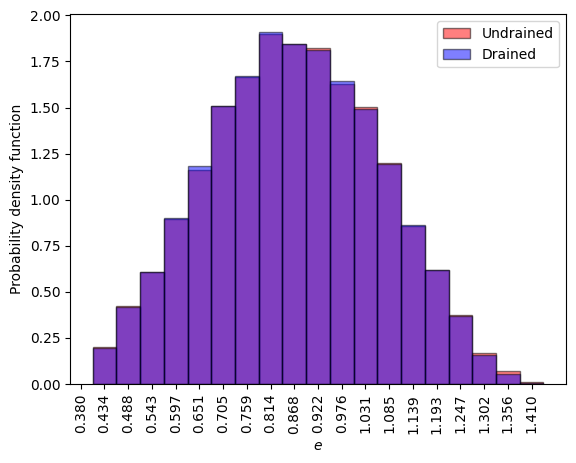

In [204]:
# We can plot the histograms of void ratios in the dataset.

ii,vv = np.histogram(comb_Txl_U.T[0].flatten(), bins=np.linspace(0.38,1.41,20),density=True)
ii2,vv2 = np.histogram(comb_Txl_D.T[0].flatten(), bins=np.linspace(0.38,1.41,20),density=True)
fig, ax = plt.subplots()
ax.bar(moving_average(vv,2), ii, width=np.diff(vv), color='red', alpha=0.5,edgecolor="black", align="edge",label="Undrained")
ax.bar(moving_average(vv2,2), ii2, width=np.diff(vv2), color='blue', alpha=0.5,edgecolor="black", align="edge",label="Drained")
ax.legend()
plt.xticks(vv,rotation = 90)
plt.xlabel(r"$e$")
plt.ylabel("Probability density function")
plt.savefig(path_root+"\\Figs_PDF\\pdfe.pdf", bbox_inches='tight')
plt.savefig(path_root+"\\Figs_PNG\\pdfe.png", bbox_inches='tight',dpi=600)
plt.show()

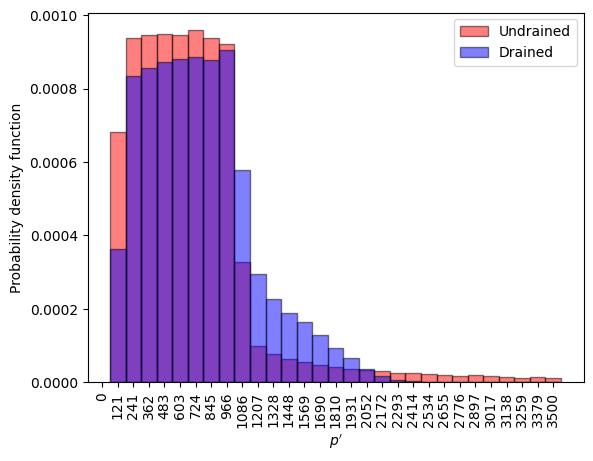

In [205]:
# We can also plot the histograms of p' in the dataset.

ii,vv = np.histogram(comb_Txl_U.T[1].flatten(), bins=np.linspace(0,3500,30),density=True)
ii2,vv2 = np.histogram(comb_Txl_D.T[1].flatten(), bins=np.linspace(0,3500,30),density=True)
fig, ax = plt.subplots()
ax.bar(moving_average(vv,2), ii, width=np.diff(vv), color='red', alpha=0.5,edgecolor="black", align="edge",label="Undrained")
ax.bar(moving_average(vv2,2), ii2, width=np.diff(vv2), color='blue', alpha=0.5,edgecolor="black", align="edge",label="Drained")
ax.legend()
plt.xticks(vv,rotation = 90)
plt.xlabel(r"$p'$")
plt.ylabel("Probability density function")
plt.savefig(path_root+"\\Figs_PDF\\pdfp.pdf", bbox_inches='tight')
plt.savefig(path_root+"\\Figs_PNG\\pdfp.png", bbox_inches='tight',dpi=600)
plt.show()

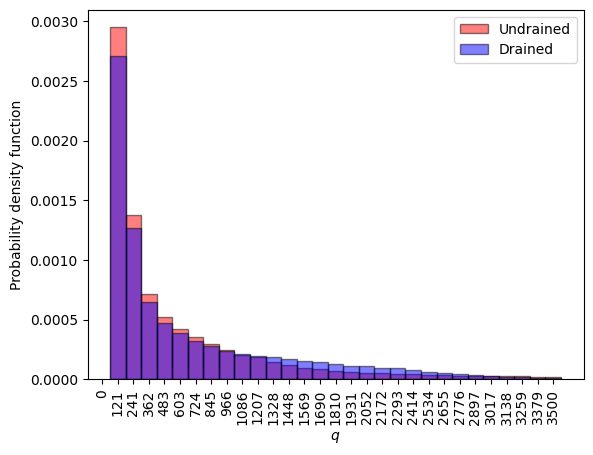

In [206]:
# Finally, we can plot the histograms of q in the dataset.

ii,vv = np.histogram(comb_Txl_U.T[2].flatten(), bins=np.linspace(0,3500,30),density=True)
ii2,vv2 = np.histogram(comb_Txl_D.T[2].flatten(), bins=np.linspace(0,3500,30),density=True)
fig, ax = plt.subplots()
ax.bar(moving_average(vv,2), ii, width=np.diff(vv), color='red', alpha=0.5,edgecolor="black", align="edge",label="Undrained")
ax.bar(moving_average(vv2,2), ii2, width=np.diff(vv2), color='blue', alpha=0.5,edgecolor="black", align="edge",label="Drained")
ax.legend()
plt.xticks(vv,rotation = 90)
plt.xlabel(r"$q$")
plt.ylabel("Probability density function")
plt.savefig(path_root+"\\Figs_PDF\\pdfq.pdf", bbox_inches='tight')
plt.savefig(path_root+"\\Figs_PNG\\pdfq.png", bbox_inches='tight',dpi=600)
plt.show()

In [7]:
# To plot the Taylor diagrams, we need to define a few auxiliary functions.

def all_stats(predicted,reference):
    pmean = np.mean(predicted,axis=0)
    rmean = np.mean(reference,axis=0)
    
    psigma = np.std(predicted,axis=0)
    rsigma = np.std(reference,axis=0)

    crmsd = np.square((predicted - pmean) - (reference - rmean))
    crmsd = np.sum(crmsd,axis=0)/predicted.shape[0]
    crmsd = np.sqrt(crmsd)
    
    # corrc = np.array([np.corrcoef(z1,z2)[0][1] for z1,z2 in zip(predicted.T,reference.T)])
    corrc = np.sum((predicted - pmean)*(reference - rmean),axis=0)/predicted.shape[0]
    corrc = corrc/(psigma*rsigma)

    return np.vstack((crmsd,psigma,rsigma,corrc))

In [46]:
# By runnning these functions, we get all the statistics needed to plot the Taylor diagrams.

typev = 'Drained'
comp_mth_D=[]
for mdl_name in Chapter_AutoML:
    with open(path_root+"Models_"+typev+"\\"+mdl_name+"-r", "rb") as f:
        ddd = pickle.load(f)
    pred_arr=[]
    true_arr=[]

    for dddi in ddd[:-1]:
        pred_arri, true_arri = ddd[0][2]
        pred_arri = pred_arri.reshape(pred_arri.shape[0]//14,14)
        true_arri = true_arri.reshape(true_arri.shape[0]//14,14)
        pred_arr.append(pred_arri)
        true_arr.append(true_arri)
    pred_arr = np.concatenate(pred_arr)
    true_arr = np.concatenate(true_arr)
    general_stats = all_stats(pred_arr.reshape(-1,1),true_arr.reshape(-1,1)).flatten()
    ast = all_stats(pred_arr,true_arr)
    comp_mth_D.append([mdl_name.split("_")[1]+"_D",np.array([ast[0]/ast[2],ast[1]/ast[2],ast[2]/ast[2],ast[3]]),general_stats])
    
comp_mth_U=[]
typev = 'Undrained'
for mdl_name in Chapter_AutoML:
    try:
        with open(path_root+"Models_"+typev+"\\"+mdl_name+"-r", "rb") as f:
            ddd = pickle.load(f)
        pred_arr=[]
        true_arr=[]

        for dddi in ddd[:-1]:
            pred_arri, true_arri = ddd[0][2]
            pred_arri = pred_arri.reshape(pred_arri.shape[0]//14,14)
            true_arri = true_arri.reshape(true_arri.shape[0]//14,14)
            pred_arr.append(pred_arri)
            true_arr.append(true_arri)
        pred_arr = np.concatenate(pred_arr)
        true_arr = np.concatenate(true_arr)
        general_stats = all_stats(pred_arr.reshape(-1,1),true_arr.reshape(-1,1)).flatten()
        ast = all_stats(pred_arr,true_arr)
        comp_mth_U.append([mdl_name.split("_")[1]+"_U",np.array([ast[0]/ast[2],ast[1]/ast[2],ast[2]/ast[2],ast[3]]),general_stats])
    except:
        pass

In [51]:
# Again, some auxiliary variables used to make the plots look good.

dict_ranges_material = {"Gamma":[0.9,1.4],"lambda":[0.01,0.07],"Mtc":[1.2,1.5],"N":[0.2,0.5],
           "Xtc": [2,5],"H0":[75,500],"Hy":[200,500], "Gmax_p0":[30,100],
           "G_exp": [0.1,0.6], "nu":[0.1,0.3]}
dict_ranges_test = {"Psi_0":[-0.2,0.2],"p0":[50,1000],
           "K0": [0.8,1.2], "OCR": [0.5,3]}

matparams = ["$\Gamma$","$\lambda$","$M_{tc}$","$N$","$\chi_{tc}$","$H_0$","$H_{\psi}$","$G_{max,p_0}$","$G_{exp}$","$\\nu$"]
exp_params = ["$\psi_0$","$p_0$","$K_0$","$OCR$"]
exp_params2 = ["$e_0$","$p_0$","$K_0$","$OCR$"]
names_pars = list(dict_ranges_material.keys())+["e0","p0","K0","OCR"]

dict_ang={}
for k in range(len(names_pars)):
    dict_ang[k]=150
dict_ang[0]=115
dict_ang[3]=115
dict_ang[4]=115
dict_ang[8]=140

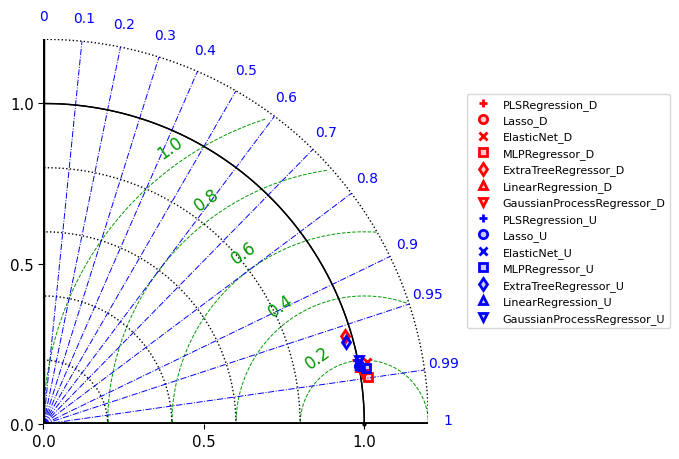

In [55]:
fig, axs = plt.subplots(1, 1, figsize=(10,5))

labels,crmsd,stdp,stdr,corrc = np.array([[cc[0]]+list(cc[2]) for cc in comp_mth_D]).T
crmsd = crmsd.astype(float)/stdr.astype(float)
stdf = stdp.astype(float)/stdr.astype(float)
corrc = corrc.astype(float)

labels2,crmsd2,stdp2,stdr2,corrc2 = np.array([[cc[0]]+list(cc[2]) for cc in comp_mth_U]).T
crmsd2 = crmsd2.astype(float)/stdr2.astype(float)
stdf2 = stdp2.astype(float)/stdr2.astype(float)
corrc2 = corrc2.astype(float)

mrkrs = ['+','o','x','s','d','^','v','p','h','*']

MARKERS = {}
for mm,cc,ll in zip(mrkrs,(['r']*len(labels)),labels):
    MARKERS[ll] = {
            "labelColor": "k",
            "symbol": mm,
            "size": 6,
            "faceColor": (cc,0.2),
            "edgeColor": cc,
        }
    
for mm,cc,ll in zip(mrkrs,(['b']*len(labels2)),labels2):
    MARKERS[ll] = {
            "labelColor": "k",
            "symbol": mm,
            "size": 6,
            "faceColor": (cc,0.2),
            "edgeColor": cc,
        }

sm.taylor_diagram(axs,
                  np.append(np.append([1],stdf),stdf2),
                  np.append(np.append([0],crmsd),crmsd2),
                  np.append(np.append([1],corrc),corrc2), 
                  markers = MARKERS,
                  markerLayout = [len(labels),1],
                  # markerLabel = ["Ref"]+list(labels), 
                  # markerLabelColor = 'k', 
                  markerLegend = 'on', 
                  # markerColor = 'r',
                  styleOBS = '-', 
                  colOBS = 'k', 
                  markerobs = 'o',
                  markerSize = 6, 
                  tickRMS = [0.2, 0.4, 0.6, 0.8,1.0],
                  tickSTD = [0.0, 0.2, 0.4, 0.6, 0.8,1.0],
                  tickRMSangle = 125, 
                  showlabelsRMS = 'on',
                  titleSTD = 'off',
                  titleCOR = 'off',
                  titleRMS = 'off',
                  alpha=0.2,
                  axisMax=1.2,
                  numberPanels=1,
                  widthRMS=0.7,
                  widthOBS=1,
                  widthSTD=1,
                  widthCOR=0.7,
                  titleRMSDangle=125)

# plt.savefig(path_root+"\\Figs_PDF\\TaylorGeneral.pdf", bbox_inches='tight')
# plt.savefig(path_root+"\\Figs_PNG\\TaylorGeneral.png", bbox_inches='tight',dpi=600)
# print(np.max(np.abs(crmsd**2-1-stdf**2+2*stdf*corrc)))

C:\Users\luano\anaconda3\Lib\site-packages\skill_metrics\taylor_diagram.py:360: RuntimeWarning: invalid value encountered in arccos
  rho, theta = STDs, np.arccos(CORs)
C:\Users\luano\anaconda3\Lib\site-packages\skill_metrics\taylor_diagram.py:360: RuntimeWarning: invalid value encountered in arccos
  rho, theta = STDs, np.arccos(CORs)


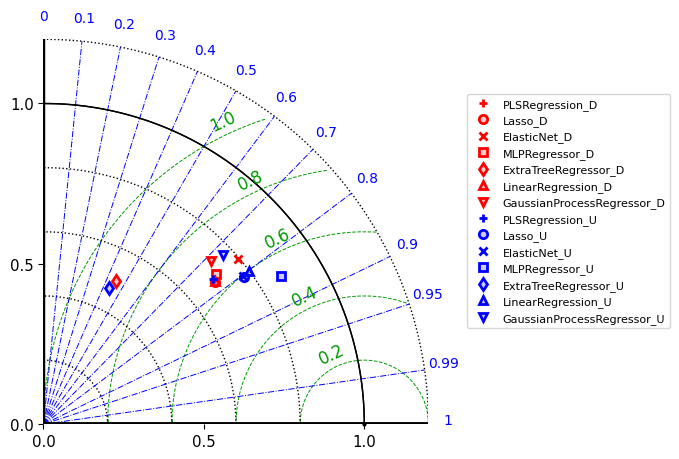

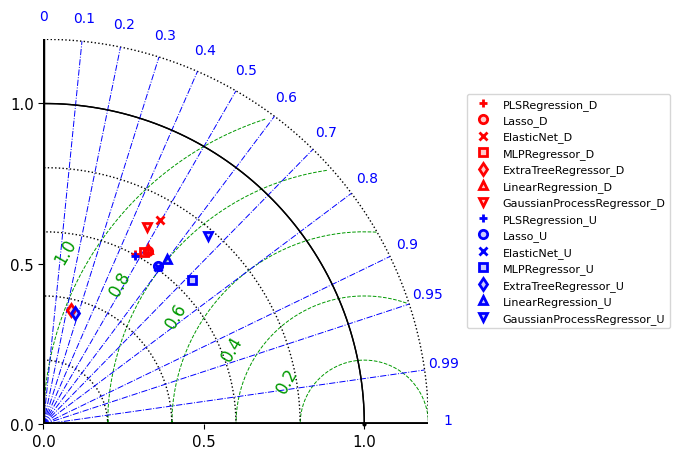

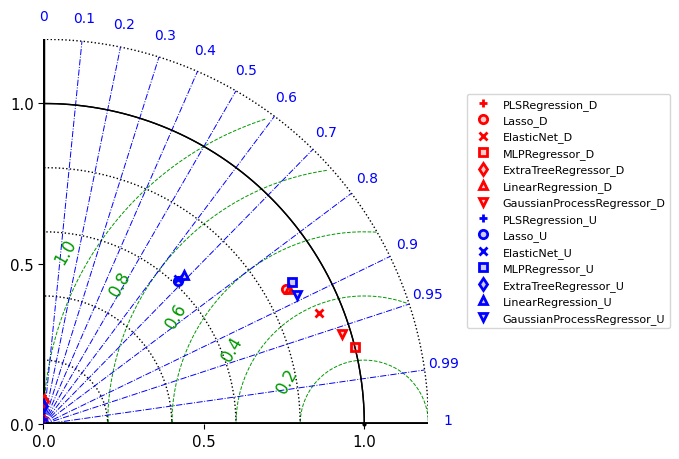

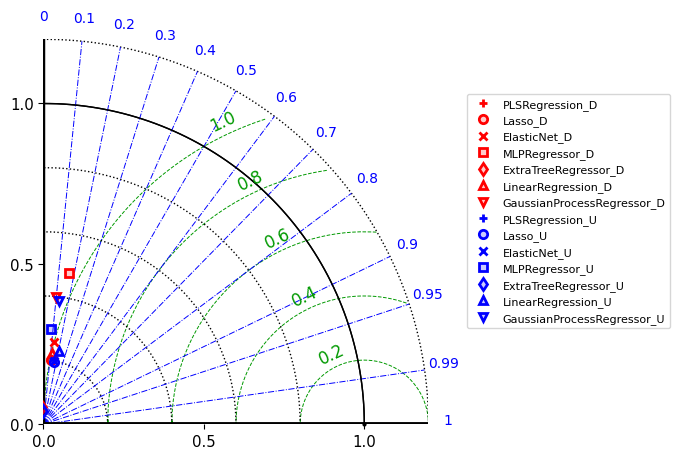

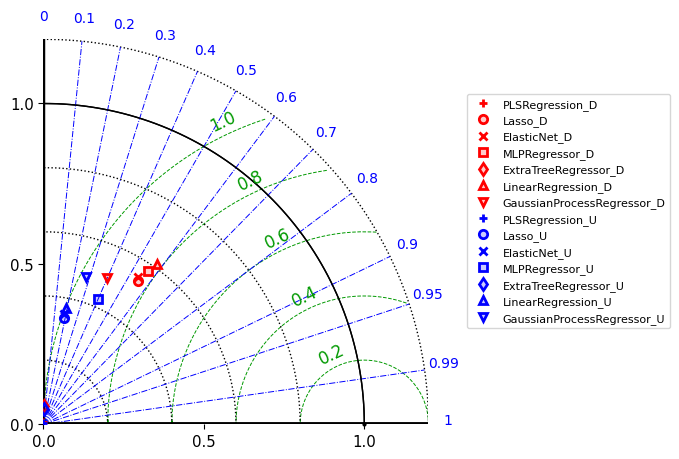

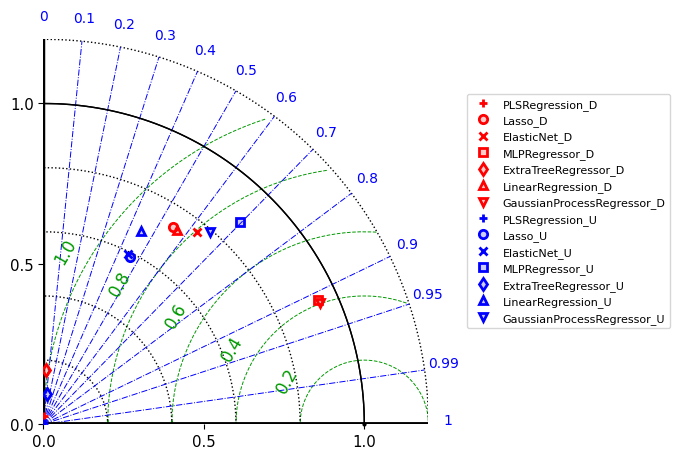

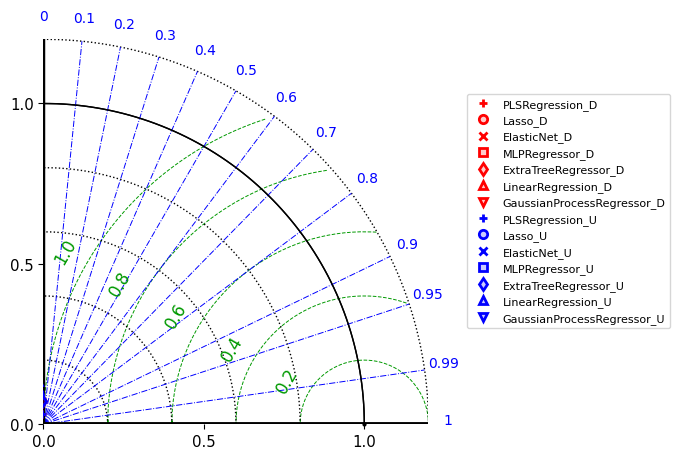

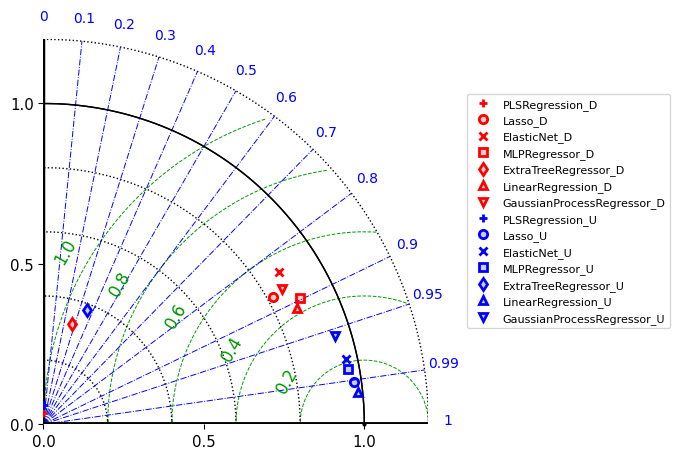

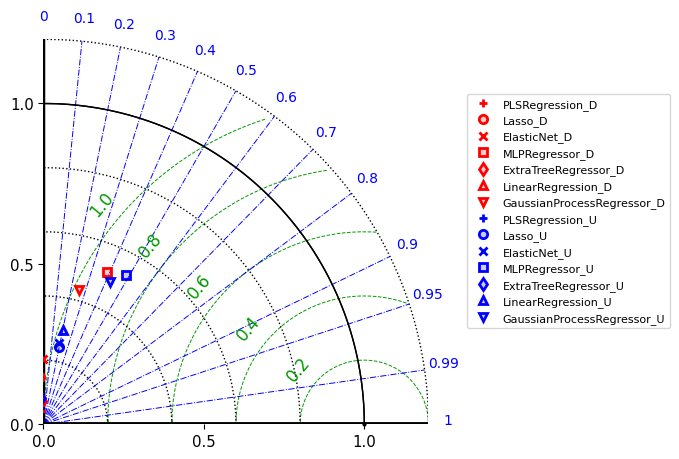

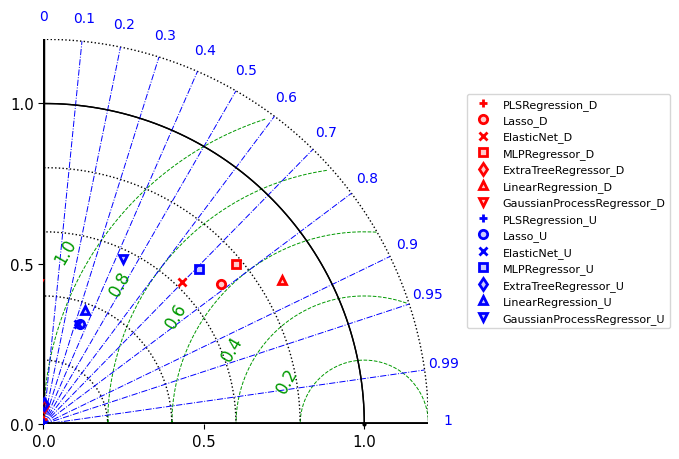

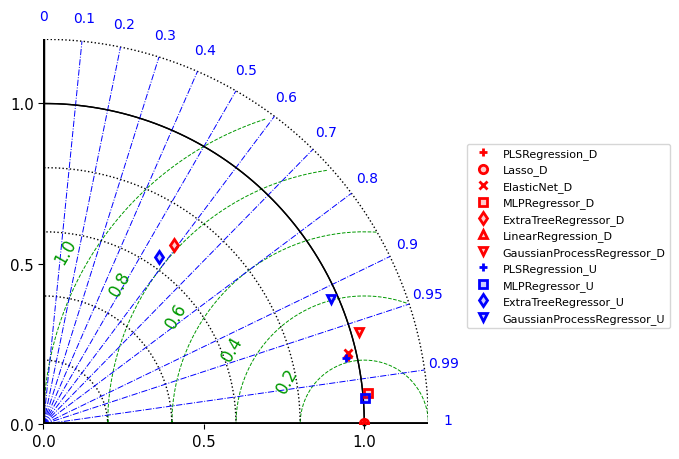

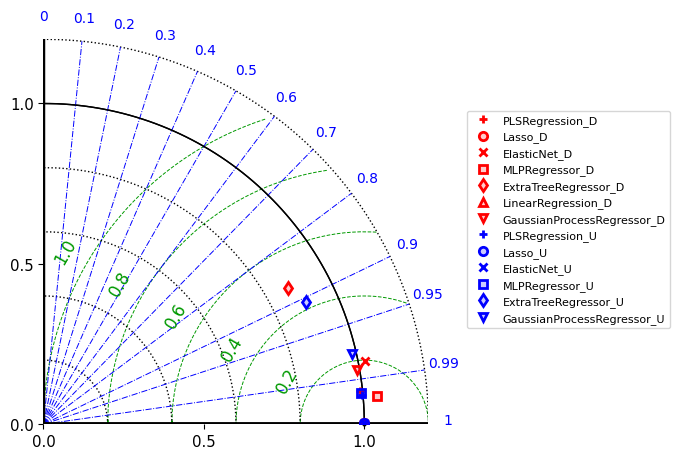

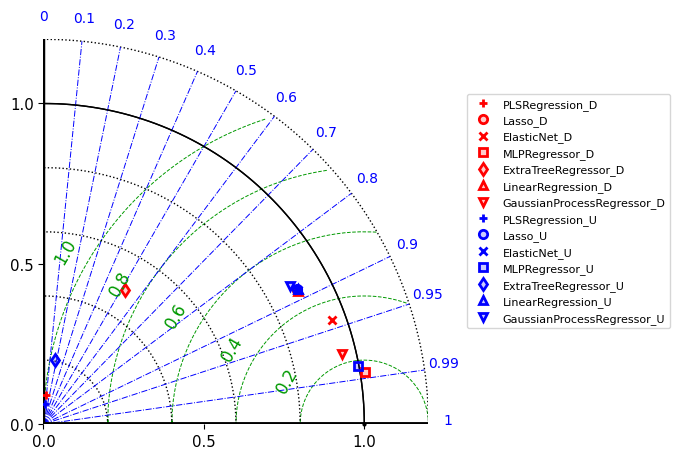

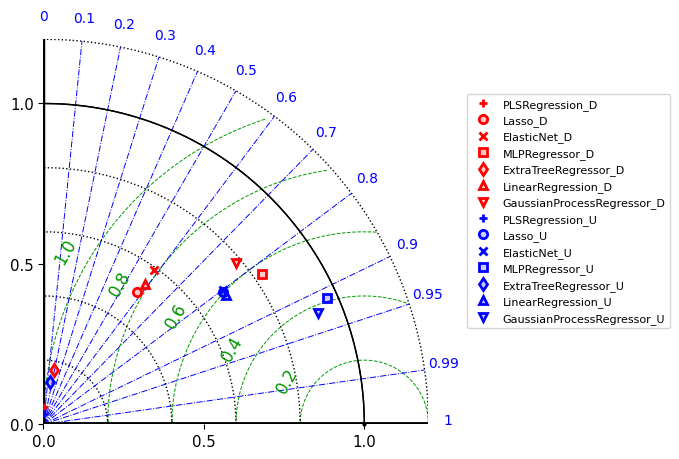

In [56]:
for k in range(len(names_pars)):
    fig, axs = plt.subplots(1, 1, figsize=(10,5))
    
    labels,crmsd,stdp,stdr,corrc = np.array([[cc[0].split("_")[1]+"_D"]+list(cc[1].T[k]) for cc in comp_mth_D]).T
    crmsd = crmsd.astype(float)/stdr.astype(float)
    stdf = stdp.astype(float)/stdr.astype(float)
    corrc = corrc.astype(float)
    
    labels2,crmsd2,stdp2,stdr2,corrc2 = np.array([[cc[0].split("_")[1]+"_D"]+list(cc[1].T[k]) for cc in comp_mth_U]).T
    crmsd2 = crmsd2.astype(float)/stdr2.astype(float)
    stdf2 = stdp2.astype(float)/stdr2.astype(float)
    corrc2 = corrc2.astype(float)
    
    sm.taylor_diagram(axs,
                      np.append(np.append([1],stdf),stdf2),
                      np.append(np.append([0],crmsd),crmsd2),
                      np.append(np.append([1],corrc),corrc2),  
                      markers = MARKERS,
                      markerLayout = [len(labels),1],
                      # markerLabelColor = 'k', 
                      markerLegend = 'on', 
                      # markerColor = 'r',
                      styleOBS = '-', 
                      colOBS = 'k', 
                      markerobs = 'o',
                      markerSize = 6, 
                      tickRMS = [0.2, 0.4, 0.6, 0.8,1.0],
                      tickSTD = [0.0, 0.2, 0.4, 0.6, 0.8,1.0],
                      tickRMSangle = dict_ang[k], 
                      showlabelsRMS = 'on',
                      titleSTD = 'off',
                      titleCOR = 'off',
                      titleRMS = 'off',
                      axisMax=1.2,
                      numberPanels=1,
                      widthRMS=0.7,
                      widthOBS=1,
                      widthSTD=1,
                      widthCOR=0.7,
                      titleRMSDangle=125)
    # plt.savefig(path_root+"\\Figs_PDF\\Taylor"+names_pars[k]+".pdf", bbox_inches='tight')
    # plt.savefig(path_root+"\\Figs_PNG\\Taylor"+names_pars[k]+".png", bbox_inches='tight',dpi=600)
    # print(np.max(np.abs(crmsd**2-1-stdf**2+2*stdf*corrc)))
    # print(np.max(np.abs(crmsd2**2-1-stdf2**2+2*stdf2*corrc2)))